# Model-Free
## Model-Free Prediction

In [1]:
# TODO

## $\epsilon$-Greedy policy

## Model-Free Control
### Sarsa 

SARSA (pour State, Action, Reward, Next State and Next Action) est un **On-Policy Control Temporal Difference algorithm**.

 - TD: Apprend à partir des valeurs courantes de la fonction valeur
 - On-Policy: Apprend les valeurs de la fonction Q à partir de la politique courante de l'agent

L'algorithme est le suivant:

Pour chaque épisode:
  1. Initialiser S
  2. Choisir une action possible A depuis S selon la politique basée sur Q (exemple: $\epsilon$-Greedy policy)
  3. Pour chaque étape de l'épisode:
    1. Appliquer l'action A', obtenir R et S'
    2. Choisir une action possible A' depuis S' selon la politique basée sur Q (exemple: $\epsilon$-Greedy policy)
    3. $Q(S, A) \leftarrow Q(S, A) + \alpha (R + \gamma Q(S', A') - Q(S, A))$
    4. S = S'
    5. A = A'

Répéter jusqu'à ce que S soit un état terminal



In [44]:
import gymnasium as gym
from random import random
from collections import defaultdict
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

def moving_average(x, w = 500):
    return np.convolve(x, np.ones(w), 'valid') / w

def visualizing_training(env, agent):
    fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
    reward_moving_average = moving_average(np.array(env.return_queue).flatten())
    length_moving_average = moving_average(np.array(env.length_queue).flatten())
    training_error_moving_average = moving_average(np.array(agent.training_error).flatten())

    axs[0].set_title("Episode rewards")
    axs[0].plot(range(len(reward_moving_average)), reward_moving_average)

    axs[1].set_title("Episode lengths")
    axs[1].plot(range(len(length_moving_average)), length_moving_average)

    axs[2].set_title("Training Error")
    axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)

    plt.tight_layout()
    plt.show() 

initial_env = gym.make('Blackjack-v1', natural=False, sab=False)

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:21<00:00, 4712.98it/s]


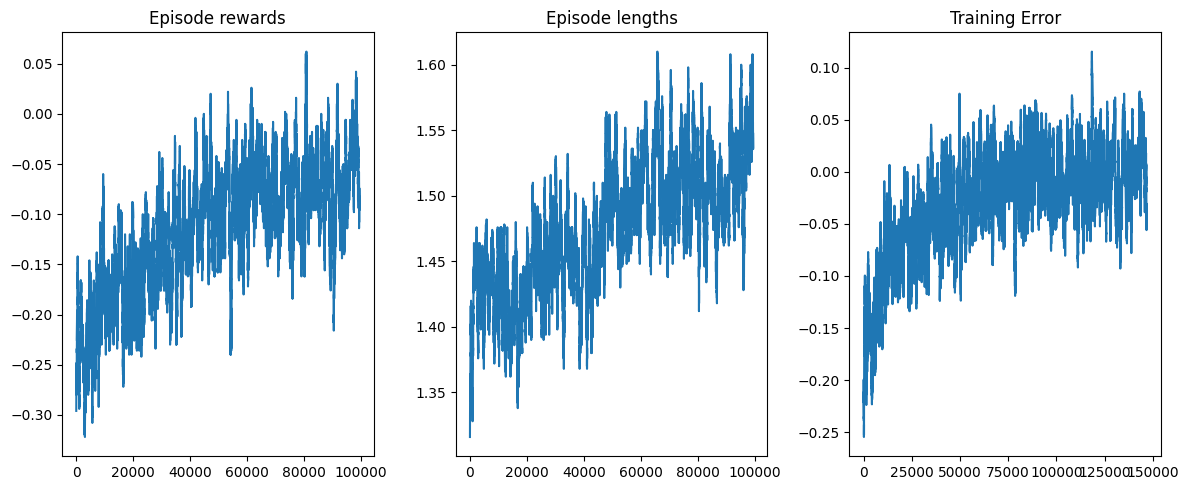

In [45]:
class SarsaBlackjackAgent:
    def __init__(
        self,
        𝛼: float = 0.01,
        𝛾: float = 0.95,
        𝜖: float = 1.0,
        𝜖_decay = 0.001
    ):
        """
        Args:
            𝛼: The learning rate
            𝜖: The epsilon value for 𝜖-Greedy policy
            𝛾: The discount factor for computing the Q-value
        """
        self.q = defaultdict(lambda: np.zeros(env.action_space.n))

        self.𝛼 = 𝛼
        self.𝛾 = 𝛾

        self.𝜖 = 𝜖
        self.m = env.action_space.n

        self.𝜖_decay = 𝜖_decay
        
        self.training_error = []

    def get_action(self, state: tuple[int, int, bool]) -> int:
        """
        𝜖-Greedy Policy Improvement
         - With probability 1 − 𝜖 choose the greedy action
         - With probability 𝜖 choose an action at random
        """
        choice = random()
        if choice < self.𝜖/self.m:
            return env.action_space.sample()
        return int(np.argmax(self.q[state]))

    def update(
        self,
        state: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_state: tuple[int, int, bool],
    ):
        next_action = self.get_action(next_state)
        temporal_difference = (reward + self.𝛾 * (not terminated) * self.q[next_state][next_action] - self.q[state][action])
        self.q[state][action] = self.q[state][action] + self.𝛼 * temporal_difference
        self.training_error.append(temporal_difference)
        return next_action

    def decay_epsilon(self):
        self.𝜖 = max(0.1, self.𝜖 - self.𝜖_decay)
        
n_episodes = 100_000
agent = SarsaBlackjackAgent(𝜖_decay = 2/n_episodes)
initial_env.reset()

# Sarsa Training
env = gym.wrappers.RecordEpisodeStatistics(intial_env, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    episode_done = False
    
    # Select A
    action = agent.get_action(obs)
    while not episode_done:
        next_obs, reward, terminated, truncated, info = env.step(action)

        # update the agent
        next_action = agent.update(obs, action, reward, terminated, next_obs)

        # update if the environment is done and the current obs
        episode_done = terminated or truncated
        obs = next_obs
        action = next_action

    agent.decay_epsilon()

visualizing_training(env, agent)

### Q-Learning

Q-Learning est un **Off-Policy Control Temporal Difference algorithm**.

 - Off-policy: met à jour Q et utilise la valeur de Q mis à jour pour prendre sa décision. Pour On-Policy, on garde la même action.

Pour chaque épisode:
  1. Initialiser S
  3. Pour chaque étape de l'épisode:
    1. Choisir une action possible A depuis S selon la politique basée sur Q (exemple: $\epsilon$-Greedy policy)
    2. Appliquer l'action A, obtenir R et S'
    3. $Q(S, A) \leftarrow Q(S, A) + \alpha (R + \gamma \max_{A'} Q(S', A') - Q(S, A))$
    4. S = S'
  Répéter jusqu'à ce que S soit un état terminal

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:21<00:00, 4600.26it/s]


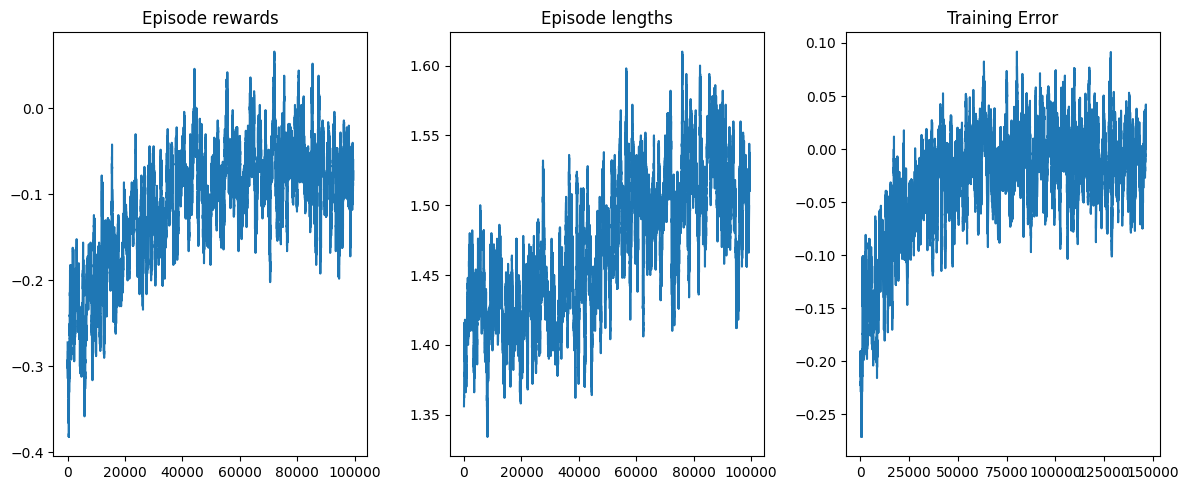

In [43]:
class QLearningBlackjackAgent:
    def __init__(
        self,
        𝛼: float = 0.01,
        𝛾: float = 0.95,
        𝜖: float = 1.0,
        𝜖_decay = 0.001
    ):
        """
        Args:
            𝛼: The learning rate
            𝜖: The epsilon value for 𝜖-Greedy policy
            𝛾: The discount factor for computing the Q-value
        """
        self.q = defaultdict(lambda: np.zeros(env.action_space.n))

        self.𝛼 = 𝛼
        self.𝛾 = 𝛾

        self.𝜖 = 𝜖
        self.m = env.action_space.n

        self.𝜖_decay = 𝜖_decay
        
        self.training_error = []

    def get_action(self, state: tuple[int, int, bool]) -> int:
        """
        𝜖-Greedy Policy Improvement
         - With probability 1 − 𝜖 choose the greedy action
         - With probability 𝜖 choose an action at random
        """
        choice = random()
        if choice < self.𝜖/self.m:
            return env.action_space.sample()
        return int(np.argmax(self.q[state]))

    def update(
        self,
        state: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_state: tuple[int, int, bool],
    ):
        next_action = self.get_action(next_state)
        temporal_difference = (reward + self.𝛾 * (not terminated) * self.q[next_state][next_action] - self.q[state][action])
        self.q[state][action] = self.q[state][action] + self.𝛼 * temporal_difference
        self.training_error.append(temporal_difference)
        return next_action

    def decay_epsilon(self):
        self.𝜖 = max(0.1, self.𝜖 - self.𝜖_decay)
        
n_episodes = 100_000
agent = QLearningBlackjackAgent(𝜖_decay = 2/n_episodes)
initial_env.reset()

# Q-Learning Training
env = gym.wrappers.RecordEpisodeStatistics(intial_env, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    episode_done = False
    
    # Répéter jusqu'à ce que S soit un état terminal
    while not episode_done:
        # 1. Choisir une action possible A depuis S selon la politique basée sur Q (exemple: $\epsilon$-Greedy policy)
        action = agent.get_action(obs)
        
        # 2. Appliquer l'action A, obtenir R et S'
        next_obs, reward, terminated, truncated, info = env.step(action)

        # 3. $Q(S, A) \leftarrow Q(S, A) + \alpha (R + \gamma \max_{A'} Q(S', A') - Q(S, A))$
        next_action = agent.update(obs, action, reward, terminated, next_obs)

        # 4. S = S'
        obs = next_obs
        episode_done = terminated or truncated

    agent.decay_epsilon()

visualizing_training(env, agent)

### Sarsa vs Q-Learning

 - SARSA: on choisit l'action suivante depuis s', on met à jour q, on applique l'action suivante (qui n'est pas toujours optimale)
 - Q-Learning: on met à jour q avec la valeur optimale des actions possibles après l'état suivant s'. On choisit l'action suivan. 

Cette petite différence entre SARSA et Q Learning rend Q learning un peu plus efficace, mais SARSA plus sûre. 